In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time
import sys

In [2]:
accumulator_kernel = 20
gaussian_kernel = 3
max_detection_radius = 100
intensity_threshold=60

In [3]:
def drawPixel(x, y, pixelData, width, height):
    if x < height and y < width:
        pixelData[x,y] += 1
    return pixelData


def paint_pixels(x, y, image):
    image[x,y,1] = 255
    image[x,y,0] = 0
    image[x,y,2] = 0
    return image

def draw_circle(x0, y0, radius, image):
    x = radius
    y = 0
    decisionOver2 = 1 - x   # Decision criterion divided by 2 evaluated at x=r, y=0

    while x >= y:
        image = paint_pixels(x + x0, y + y0, image)
        image = paint_pixels(y + x0, x + y0, image)
        image = paint_pixels(-x + x0, y + y0, image)
        image = paint_pixels(-y + x0, x + y0, image)
        image = paint_pixels(-x + x0, -y + y0, image)
        image = paint_pixels(-y + x0, -x + y0, image)
        image = paint_pixels(x + x0, -y + y0, image)
        image = paint_pixels(y + x0, -x + y0, image)
        y+=1
        if decisionOver2 <= 0:
            decisionOver2 += 2 * y + 1 # Change in decision criterion for y -> y+1
        else:
            x-=1
            decisionOver2 += 2 * (y - x) + 1 # Change for y -> y+1, x -> x-1
    return image

def accumulator_data(x0, y0, radius, pixelData, width, height):
    ''' This is the implementation of Midpoint Circle Algorithm. Refer the report for more details. '''
    x = radius
    y = 0
    decisionOver2 = 1 - x   # Decision criterion divided by 2 evaluated at x=r, y=0

    while x >= y:
        pixelData = drawPixel(x + x0, y + y0, pixelData, width, height)
        pixelData = drawPixel(y + x0, x + y0, pixelData, width, height)
        pixelData = drawPixel(-x + x0, y + y0, pixelData, width, height)
        pixelData = drawPixel(-y + x0, x + y0, pixelData, width, height)
        pixelData = drawPixel(-x + x0, -y + y0, pixelData, width, height)
        pixelData = drawPixel(-y + x0, -x + y0, pixelData, width, height)
        pixelData = drawPixel(x + x0, -y + y0, pixelData, width, height)
        pixelData = drawPixel(y + x0, -x + y0, pixelData, width, height)
        y+=1
        if decisionOver2 <= 0:
            decisionOver2 += 2 * y + 1 # Change in decision criterion for y -> y+1
        else:
            x-=1
            decisionOver2 += 2 * (y - x) + 1 # Change for y -> y+1, x -> x-1
    return pixelData

def get_edge_locations(edged_image):
    edges = np.where(edged_image==255)
    return edges

def get_max_possible_radius(edges, max_detection_radius):
    xmin = min(edges[0])
    xmax = max(edges[0])

    ymin = min(edges[1])
    ymax = max(edges[1])

    return min(min(xmax-xmin, ymax-ymin)/2,max_detection_radius)

def construct_accumulator_array(edges, width, height, max_radius):
    acc_array = np.zeros(((height,width,max_radius)))
    for radius in range(5, max_radius):
        for i in range(0,len(edges[0])):
            x=edges[0][i]
            y=edges[1][i]
            acc_array[:,:,radius] = accumulator_data(x,y,radius, acc_array[:,:,radius], width, height)
    return acc_array

def threshold_accumulator_plot_circles(output, acc_array, max_radius, width, height, intensity_threshold, accumulator_kernel):
    i, j = 0, 0
    filter_patch = accumulator_kernel
    center_loc_filter = np.ones((filter_patch,filter_patch,max_radius))
    while(i<height-filter_patch):
        while(j<width-filter_patch):
            center_loc_filter=acc_array[i:i+filter_patch,j:j+filter_patch,:] * center_loc_filter
            max_pt = np.where(center_loc_filter==center_loc_filter.max())
            x0 = max_pt[0]       
            y0 = max_pt[1]
            radius = max_pt[2]
            y0 += j
            x0 += i
            if(center_loc_filter.max()>intensity_threshold):
                try:
                    if len(x0) > 1 and len(y0) > 1 and len(radius) > 1:
                        x0 = x0[0]
                        y0 = y0[0]
                        radius = radius[0]
                    output = draw_circle(x0, y0, radius, output)
                except Exception as e:
                    print(e)
 
            j=j+filter_patch
            center_loc_filter[:,:,:]=1
        j=0
        i=i+filter_patch
    return output

# Normal scenario

In [4]:
src = cv.imread(cv.samples.findFile('a.png'))

(461, 501)

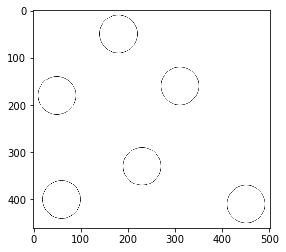

In [5]:
gray_image = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
plt.imshow(gray_image,cmap='gray')
gray_image.shape

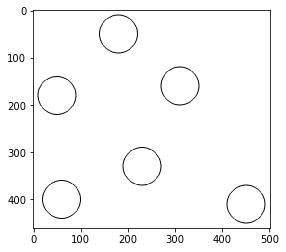

In [6]:
output = src.copy()
blur_image = cv.GaussianBlur(gray_image,(gaussian_kernel,gaussian_kernel),0)
plt.imshow(blur_image,cmap='gray')

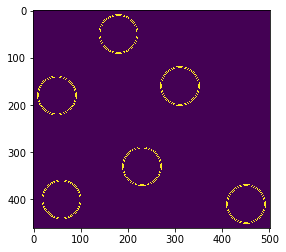

In [7]:
edged_image = cv.Canny(blur_image,3,3)
plt.imshow(edged_image)
height,width = edged_image.shape
edges = get_edge_locations(edged_image)

In [8]:
max_radius = get_max_possible_radius(edges, max_detection_radius)
max_radius

100

In [9]:
acc_array = construct_accumulator_array(edges, width, height, max_radius)

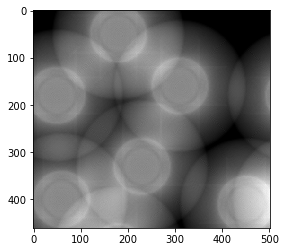

In [10]:
plt.imshow(np.sum(np.copy(acc_array),axis=2),cmap='gray')

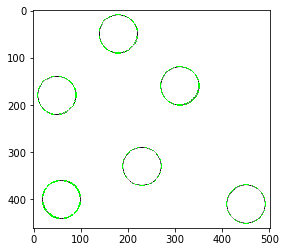

In [11]:
output = threshold_accumulator_plot_circles(output, acc_array, max_radius, width, height, intensity_threshold, accumulator_kernel)  
plt.imshow(output,cmap='gray')

W tym scenariuszu transformata została skalibrowana, również zweryfikowałem czy kod działa poprawnie. W akumulatorze transformaty widzimy że najwięcej głosów ozyskały miejsca pokrywające się z położeniem okręgów. Widać również jak transformata `szuka` okręgów o większym jak i mniejszym promieniu. Zostało zastosowane delikatne rozmycie aby okręgi były trochę grubsze.

# Strong Blur scenario

In [12]:
src = cv.imread(cv.samples.findFile('a.png'))

(461, 501)

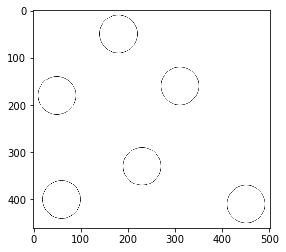

In [13]:
gray_image = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
plt.imshow(gray_image,cmap='gray')
gray_image.shape

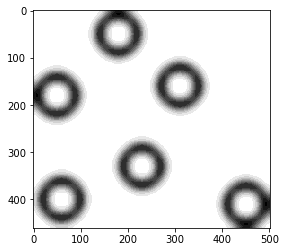

In [14]:
output = src.copy()
blur_image = cv.GaussianBlur(gray_image,(63,63),0)
plt.imshow(blur_image,cmap='gray')

 Z tak mocno rozmytym obrazem trudno jest nawet wykryć krawędzie

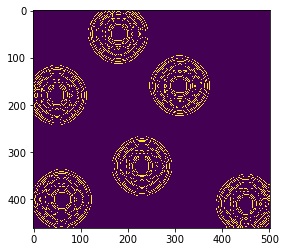

In [15]:
edged_image = cv.Canny(blur_image,3,3)
plt.imshow(edged_image)
height,width = edged_image.shape
edges = get_edge_locations(edged_image)
plt.imshow(edged_image)

In [16]:
max_radius = get_max_possible_radius(edges, max_detection_radius)
max_radius

100

In [17]:
acc_array = construct_accumulator_array(edges, width, height, max_radius)

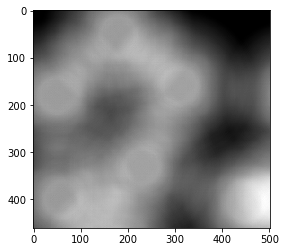

In [18]:
plt.imshow(np.sum(np.copy(acc_array),axis=2),cmap='gray')

index 519 is out of bounds for axis 1 with size 501
index 539 is out of bounds for axis 1 with size 501
index 515 is out of bounds for axis 1 with size 501
index 515 is out of bounds for axis 1 with size 501
index 515 is out of bounds for axis 1 with size 501
index 515 is out of bounds for axis 1 with size 501
index 555 is out of bounds for axis 1 with size 501
index 562 is out of bounds for axis 1 with size 501
index 592 is out of bounds for axis 1 with size 501
index 548 is out of bounds for axis 1 with size 501
index 558 is out of bounds for axis 1 with size 501
index 584 is out of bounds for axis 1 with size 501
index 546 is out of bounds for axis 1 with size 501
index 575 is out of bounds for axis 1 with size 501
index 586 is out of bounds for axis 1 with size 501
index 537 is out of bounds for axis 1 with size 501
index 594 is out of bounds for axis 1 with size 501
index 550 is out of bounds for axis 1 with size 501
index 550 is out of bounds for axis 1 with size 501
index 594 is

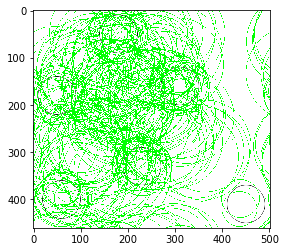

In [19]:
output = threshold_accumulator_plot_circles(output, acc_array, max_radius, width, height, intensity_threshold, accumulator_kernel)  
plt.imshow(output,cmap='gray')

Widzimy że silne rozmycie zupełnie zmyliło transformatę. Na akumulatorze widzimy ze że co prawda obszary gdzie znajdują się okręgi otrzymują sporo głosów, natomiast są bardzo zagłuszone przez otoczenie. W tym scenariuszu musiałem również obniżyć progi gdż w przeciwnym wypadku okręgni nie były zupełnie wykrywane.

# 'Salt and Pepper' filter scenario

In [20]:
src = cv.imread(cv.samples.findFile('a.png'))

(461, 501)

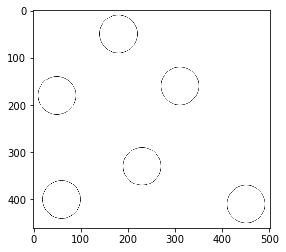

In [21]:
gray_image = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
plt.imshow(gray_image,cmap='gray')
gray_image.shape

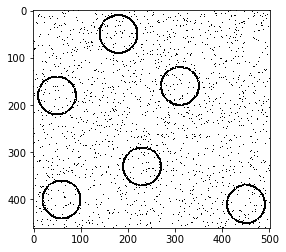

In [22]:
from skimage.util import random_noise
output = src.copy()
blur_image = np.uint8(random_noise(cv.GaussianBlur(gray_image,(gaussian_kernel,gaussian_kernel),0), mode='s&p',amount=0.07))
plt.imshow(blur_image,cmap='gray')

(array([  0,   0,   0, ..., 460, 460, 460]),
 array([ 41,  43,  46, ..., 475, 476, 500]))

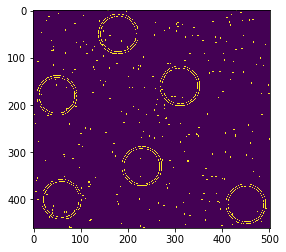

In [23]:
edged_image = cv.Canny(blur_image,3,3,3)
height,width = edged_image.shape
plt.imshow(edged_image)
edges = get_edge_locations(edged_image)
edges

In [24]:
max_radius = get_max_possible_radius(edges, max_detection_radius)
max_radius

100

In [25]:
acc_array = construct_accumulator_array(edges, width, height, max_radius)

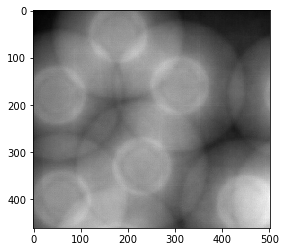

In [26]:
plt.imshow(np.sum(np.copy(acc_array),axis=2),cmap='gray')

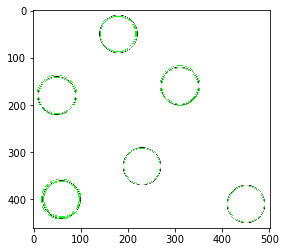

In [27]:
output = threshold_accumulator_plot_circles(output, acc_array, max_radius, width, height, intensity_threshold, accumulator_kernel)  
plt.imshow(output,cmap='gray')

Widzimy że filtr 'salt and pepper' nie zmylił transformaty zupełnie, co prawda filtr nie był bardzo intensywny, ale udało mu się i tak zmniejszyć precyzję wykrywanych okręgów. Widzimy że zielone i czarne okręgi nie pokrywają się całkowicie.

# Different sizes scenario

In [28]:
src = cv.imread(cv.samples.findFile('b.png'))

(461, 501)

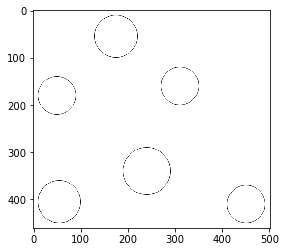

In [29]:
gray_image = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
plt.imshow(gray_image,cmap='gray')
gray_image.shape

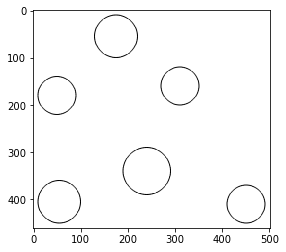

In [30]:
output = src.copy()
blur_image = cv.GaussianBlur(gray_image,(gaussian_kernel,gaussian_kernel),0)
plt.imshow(blur_image,cmap='gray')

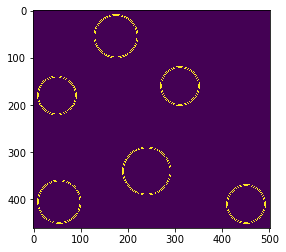

In [31]:
edged_image = cv.Canny(blur_image,3,3)
plt.imshow(edged_image)
height,width = edged_image.shape
edges = get_edge_locations(edged_image)

In [32]:
max_radius = get_max_possible_radius(edges, max_detection_radius)
max_radius

100

In [33]:
acc_array = construct_accumulator_array(edges, width, height, max_radius)

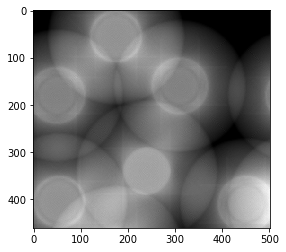

In [34]:
plt.imshow(np.sum(np.copy(acc_array),axis=2),cmap='gray')

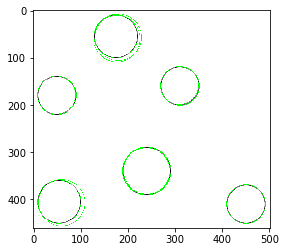

In [35]:
output = threshold_accumulator_plot_circles(output, acc_array, max_radius, width, height, intensity_threshold, accumulator_kernel)  
plt.imshow(output,cmap='gray')

Kółka rożnej wielkości zostały wykryte natomiast zniekształciły one wyniki na sąsiadujących okręgach.

# Circles with Elipses scenario

In [36]:
src = cv.imread(cv.samples.findFile('c.png'))

(401, 501)

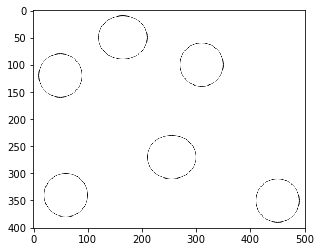

In [37]:
gray_image = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
plt.imshow(gray_image,cmap='gray')
gray_image.shape

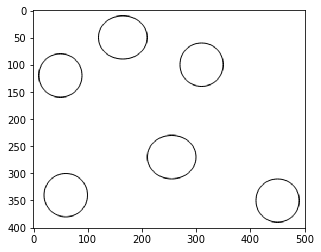

In [38]:
output = src.copy()
blur_image = cv.GaussianBlur(gray_image,(gaussian_kernel,gaussian_kernel),0)
plt.imshow(blur_image,cmap='gray')

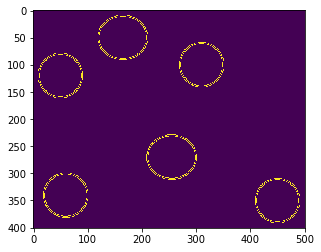

In [39]:
edged_image = cv.Canny(blur_image,3,3)
plt.imshow(edged_image)
height,width = edged_image.shape
edges = get_edge_locations(edged_image)

In [40]:
max_radius = get_max_possible_radius(edges, max_detection_radius)
max_radius

100

In [41]:
acc_array = construct_accumulator_array(edges, width, height, max_radius)

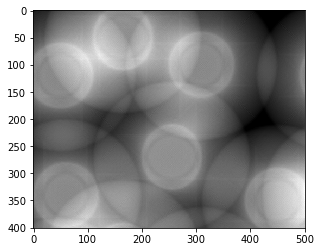

In [42]:
plt.imshow(np.sum(np.copy(acc_array),axis=2),cmap='gray')

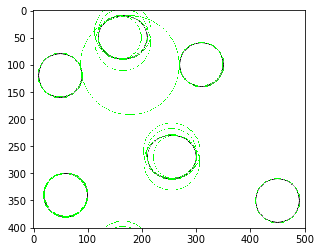

In [43]:
output = threshold_accumulator_plot_circles(output, acc_array, max_radius, width, height, intensity_threshold, accumulator_kernel)  
plt.imshow(output,cmap='gray')

Widzimy że elipsy są dużo trudniejsze niż okręgi o lekko różnych kształtac, tym razem elipsy dostały po kilka dopasowań, na każdą elipsę zostało wykryte kilka kółek, co nie dziwi że wykryte okręgi są styczne do elips.

# With non circular shapes scenario

In [44]:
src = cv.imread(cv.samples.findFile('d.png'))

(501, 581)

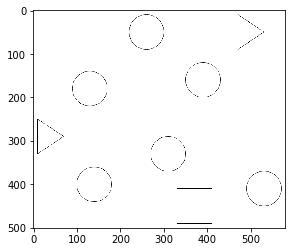

In [45]:
gray_image = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
plt.imshow(gray_image,cmap='gray')
gray_image.shape

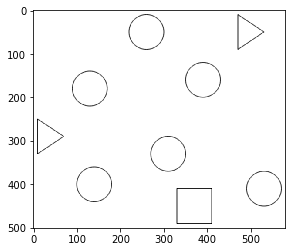

In [46]:
output = src.copy()
blur_image = cv.GaussianBlur(gray_image,(gaussian_kernel,gaussian_kernel),0)
plt.imshow(blur_image,cmap='gray')

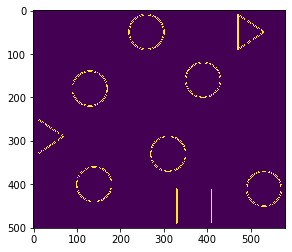

In [47]:
edged_image = cv.Canny(blur_image,3,3)
plt.imshow(edged_image)
height,width = edged_image.shape
edges = get_edge_locations(edged_image)

In [48]:
max_radius = get_max_possible_radius(edges, max_detection_radius)
max_radius

100

In [49]:
acc_array = construct_accumulator_array(edges, width, height, max_radius)

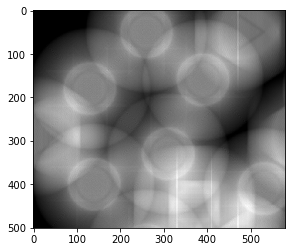

In [50]:
plt.imshow(np.sum(np.copy(acc_array),axis=2),cmap='gray')

index 511 is out of bounds for axis 0 with size 501
index 531 is out of bounds for axis 0 with size 501
index 525 is out of bounds for axis 0 with size 501
index 549 is out of bounds for axis 0 with size 501
index 563 is out of bounds for axis 0 with size 501


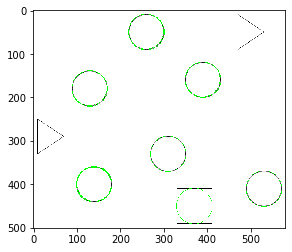

In [51]:
output = threshold_accumulator_plot_circles(output, acc_array, max_radius, width, height, intensity_threshold, accumulator_kernel)  
plt.imshow(output,cmap='gray')

Kształty nie koliste nie spododowały zakłuceń, wyjątkiem może być kwadrat gdzie transformata próbuje wpisać w niego okrąg, natomiast dało by się go usunąć dobierając lepiej progi, obecne progi są takie same jak w przypadku bazowym, aby móc zaobserować zachodzące zmiany.

# Overlaping circles scenario

In [52]:
src = cv.imread(cv.samples.findFile('e.png'))

(461, 501)

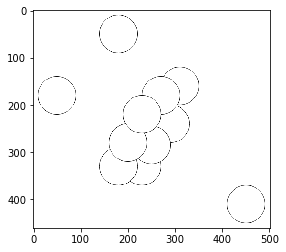

In [53]:
gray_image = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
plt.imshow(gray_image,cmap='gray')
gray_image.shape

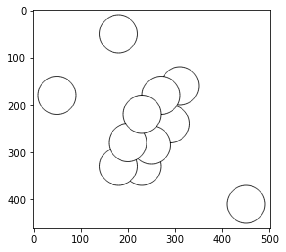

In [54]:
output = src.copy()
blur_image = cv.GaussianBlur(gray_image,(gaussian_kernel,gaussian_kernel),0)
plt.imshow(blur_image,cmap='gray')

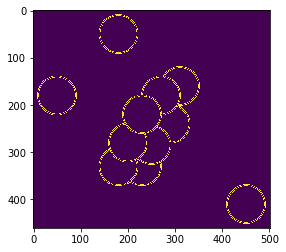

In [55]:
edged_image = cv.Canny(blur_image,3,3)
plt.imshow(edged_image)
height,width = edged_image.shape
edges = get_edge_locations(edged_image)

In [56]:
max_radius = get_max_possible_radius(edges, max_detection_radius)
max_radius

100

In [57]:
acc_array = construct_accumulator_array(edges, width, height, max_radius)

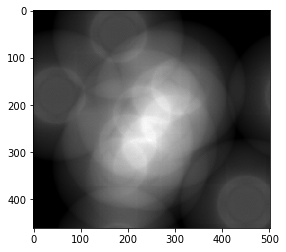

In [58]:
plt.imshow(np.sum(np.copy(acc_array),axis=2),cmap='gray')

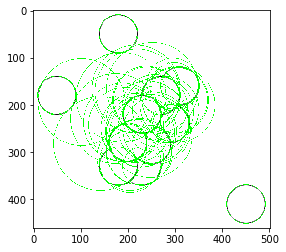

In [59]:
output = threshold_accumulator_plot_circles(output, acc_array, max_radius, width, height, intensity_threshold, accumulator_kernel)  
plt.imshow(output,cmap='gray')

Transformata radzi sobie z zachodzącymi na siebie kołami, natomiast takie ich ustawienie powoduje istotny wzrost szumu na akumulatorze, który można odfiltrować za pomocą wyższych progów, Na akumulatorze widać że zbiorowisko okręgów jest wyraźnie jasną palmą.